## Produce digits of power

In [35]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

import random
import pickle

import sklearn.datasets
import sklearn.model_selection

from sklearn import preprocessing

import sklearn.neural_network

import neural_network_repn
setattr(sklearn,'neural_network',neural_network_repn)

In [36]:
from keras.datasets import mnist
from keras.layers import Dense, Flatten
(X, y), (x_test, y_test) = mnist.load_data()

Preprocessing

In [37]:
Ns = [2,4,6,8,10]

In [38]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def relu(x):
    for i in range(len(x)):
        x[i] = np.max((0,x[i]))
    return x
def hill(x,n,theta):
#     return x**n
    return x**n/(x**n + theta**n)
def score(x,use_hill,N,theta,mlp):
    W = mlp.coefs_
    b = mlp.intercepts_
    if use_hill:
        y = hill(x,N,theta)
    else:
        y = x[:]
    return sigmoid(np.dot(sigmoid(np.dot(y,W[0])+b[0]),W[1])+b[1])
def grad_score(x,use_hill,N,theta,mlp):
    grad = np.zeros(x.shape)
    for i in range(len(x)):
        yp = x.copy(); yp[i] += 10/255; 
        ym = x.copy(); ym[i] -= 10/255;
        grad[i] = 255/2*(score(yp,use_hill,N,theta,mlp)-score(ym,use_hill,N,theta,mlp))
    return grad

In [39]:
X=X/255
XT=x_test/255
yT=y_test

In [40]:
X=X.reshape(len(X), 28**2)
XT=XT.reshape(len(XT), 28**2)

In [41]:
# Call MNIST and keep 3s and 7s
#mnist = sklearn.datasets.fetch_mldata("MNIST original")

# Rescale the data and extract all images for two digits
#X, y = mnist.data / 255., mnist.target

index = np.where((y == 3) | (y == 7))[0]
X0,y = X[index], y[index]

Index = np.where((yT == 3) | (yT == 7))[0]
XT,yT = XT[Index], yT[Index]

X0_train1, X0_train2, y_train1, y_train2 = sklearn.model_selection.train_test_split(X0, y, test_size=0.5)

Training

In [42]:
small_neural = sklearn.neural_network.MLPClassifier(activation = "relu", hidden_layer_sizes=(4,), max_iter = 500, solver='sgd', random_state=5, learning_rate = 'adaptive',verbose = 1)
small_neural.fit(X0_train1,y_train1)


Iteration 1, loss = 0.68532570
Iteration 2, loss = 0.54169603
Iteration 3, loss = 0.45590040
Iteration 4, loss = 0.41169568
Iteration 5, loss = 0.38324967
Iteration 6, loss = 0.36206907
Iteration 7, loss = 0.34476738
Iteration 8, loss = 0.32997236
Iteration 9, loss = 0.31707564
Iteration 10, loss = 0.30546932
Iteration 11, loss = 0.29496854
Iteration 12, loss = 0.28542674
Iteration 13, loss = 0.27649154
Iteration 14, loss = 0.26825278
Iteration 15, loss = 0.26055771
Iteration 16, loss = 0.25338672
Iteration 17, loss = 0.24660802
Iteration 18, loss = 0.24032469
Iteration 19, loss = 0.23432757
Iteration 20, loss = 0.22868381
Iteration 21, loss = 0.22334239
Iteration 22, loss = 0.21829543
Iteration 23, loss = 0.21351398
Iteration 24, loss = 0.20899333
Iteration 25, loss = 0.20460361
Iteration 26, loss = 0.20048637
Iteration 27, loss = 0.19651923
Iteration 28, loss = 0.19276620
Iteration 29, loss = 0.18915783
Iteration 30, loss = 0.18572761
Iteration 31, loss = 0.18240273
Iteration 32, los

Iteration 252, loss = 0.05208441
Iteration 253, loss = 0.05193910
Iteration 254, loss = 0.05181898
Iteration 255, loss = 0.05167718
Iteration 256, loss = 0.05153749
Iteration 257, loss = 0.05140896
Iteration 258, loss = 0.05131116
Iteration 259, loss = 0.05121417
Iteration 260, loss = 0.05099777
Iteration 261, loss = 0.05088870
Iteration 262, loss = 0.05073963
Iteration 263, loss = 0.05060010
Iteration 264, loss = 0.05047814
Iteration 265, loss = 0.05033955
Iteration 266, loss = 0.05020421
Iteration 267, loss = 0.05007508
Iteration 268, loss = 0.04995605
Iteration 269, loss = 0.04985030
Iteration 270, loss = 0.04969391
Iteration 271, loss = 0.04959453
Iteration 272, loss = 0.04944792
Iteration 273, loss = 0.04932505
Iteration 274, loss = 0.04919684
Iteration 275, loss = 0.04908907
Iteration 276, loss = 0.04897236
Iteration 277, loss = 0.04882965
Iteration 278, loss = 0.04872629
Iteration 279, loss = 0.04862656
Iteration 280, loss = 0.04846689
Iteration 281, loss = 0.04835050
Iteration 

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(4,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=5, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=1,
       warm_start=False)

In [43]:
use_hill=False;N=10;theta=0.5
grad,pm = [],[]
print(XT.shape)
for i in range(len(XT)):
    x0 = XT[i]
    grad.append(grad_score(x0,use_hill,N,theta,small_neural))
    pm.append((yT[i]-5)/2) #3 -> -1; 7 -> +1
grad = np.asarray(grad)
pm = np.asarray(pm)

(2038, 784)


In [44]:
def hill(x,n,theta):
#     return x**n
    return x**n/(x**n + theta**n)

Stacked Model

In [45]:
theta = 0.5
middle_SM = np.zeros((len(Ns),len(X0_train2)))
for idx_N,N in enumerate(Ns):
    X = hill(X0_train2,N,theta)
    middle_SM[idx_N]=small_neural.predict(X)

In [46]:
middle_SM=np.transpose(middle_SM)
middle_SM.shape

(6198, 5)

In [47]:
'''import sklearn.neural_network

import neural_network_repn
setattr(sklearn,'neural_network',neural_network_repn)'''
master_neural = sklearn.neural_network.MLPClassifier(activation = "logistic", hidden_layer_sizes=(5,), max_iter = 500, solver='sgd', random_state=5, learning_rate = 'adaptive',verbose = 1)
#middle_SM = np.log(middle_SM)
master_neural.fit(middle_SM,y_train2)

Iteration 1, loss = 0.71727759
Iteration 2, loss = 0.68896476
Iteration 3, loss = 0.67292751
Iteration 4, loss = 0.66452384
Iteration 5, loss = 0.65927791
Iteration 6, loss = 0.65522958
Iteration 7, loss = 0.65181601
Iteration 8, loss = 0.64894296
Iteration 9, loss = 0.64647141
Iteration 10, loss = 0.64431654
Iteration 11, loss = 0.64233506
Iteration 12, loss = 0.64048504
Iteration 13, loss = 0.63871656
Iteration 14, loss = 0.63701906
Iteration 15, loss = 0.63534583
Iteration 16, loss = 0.63371670
Iteration 17, loss = 0.63211948
Iteration 18, loss = 0.63055115
Iteration 19, loss = 0.62899100
Iteration 20, loss = 0.62744207
Iteration 21, loss = 0.62590948
Iteration 22, loss = 0.62437521
Iteration 23, loss = 0.62286226
Iteration 24, loss = 0.62133596
Iteration 25, loss = 0.61980221
Iteration 26, loss = 0.61828448
Iteration 27, loss = 0.61675650
Iteration 28, loss = 0.61525405
Iteration 29, loss = 0.61369044
Iteration 30, loss = 0.61214700
Iteration 31, loss = 0.61060381
Iteration 32, los

Iteration 260, loss = 0.13364122
Iteration 261, loss = 0.13294005
Iteration 262, loss = 0.13221867
Iteration 263, loss = 0.13153380
Iteration 264, loss = 0.13082748
Iteration 265, loss = 0.13016063
Iteration 266, loss = 0.12948950
Iteration 267, loss = 0.12884053
Iteration 268, loss = 0.12818120
Iteration 269, loss = 0.12753881
Iteration 270, loss = 0.12690060
Iteration 271, loss = 0.12626513
Iteration 272, loss = 0.12567181
Iteration 273, loss = 0.12504343
Iteration 274, loss = 0.12444514
Iteration 275, loss = 0.12386888
Iteration 276, loss = 0.12330343
Iteration 277, loss = 0.12272019
Iteration 278, loss = 0.12215459
Iteration 279, loss = 0.12160550
Iteration 280, loss = 0.12107575
Iteration 281, loss = 0.12053788
Iteration 282, loss = 0.12001190
Iteration 283, loss = 0.11952200
Iteration 284, loss = 0.11899082
Iteration 285, loss = 0.11849125
Iteration 286, loss = 0.11799853
Iteration 287, loss = 0.11751882
Iteration 288, loss = 0.11704670
Iteration 289, loss = 0.11658362
Iteration 

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=5, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=1,
       warm_start=False)

Hidden-layer feed in

In [48]:
#Weights and Biases for Hidden Layer
w1 = small_neural.coefs_[0]
b1 = small_neural.intercepts_[0]

In [49]:
theta = 0.5
middle_HFI = np.zeros(shape=(len(X0_train2),len(Ns),4))
for idx_N,N in enumerate(Ns):
    X = hill(X0_train2,N,theta)
    for i in range(len(X0_train2)):
        h1=np.matmul(X0_train2[i],w1) + b1
        h1=np.maximum(0, h1)
        middle_HFI[i][idx_N]=h1
print(middle_HFI.shape)

(6198, 5, 4)


In [51]:
middle_HFI=middle_HFI.reshape(6198,4*len(Ns))

In [52]:
HFI = sklearn.neural_network.MLPClassifier(activation = "logistic", hidden_layer_sizes=(5,), max_iter = 500, solver='sgd', random_state=5, learning_rate = 'adaptive',verbose = 1)
'''for i, middle in enumerate(middle_HFI):
    middle[middle==0] = 1
    middle_HFI[i] = middle
middle_HFI = np.log(np.abs(middle_HFI))'''
HFI.fit(middle_HFI,y_train2)
'''(a,b)=HFI.coefs_
a2 = a.flatten()
c = []
for i in range(len(a2)):
    if a2[i] >= 0:
        c.append(int(a2[i]+1/2))
    else:
        c.append(-int(np.abs(a2[i]-1/2)))

c = np.array(c).reshape(a.shape)
HFI.coefs_[0] = c'''

Iteration 1, loss = 0.65377235
Iteration 2, loss = 0.63225205
Iteration 3, loss = 0.61178907
Iteration 4, loss = 0.59311702
Iteration 5, loss = 0.57545666
Iteration 6, loss = 0.55871529
Iteration 7, loss = 0.54260954
Iteration 8, loss = 0.52732164
Iteration 9, loss = 0.51260418
Iteration 10, loss = 0.49849456
Iteration 11, loss = 0.48488527
Iteration 12, loss = 0.47175075
Iteration 13, loss = 0.45903245
Iteration 14, loss = 0.44673731
Iteration 15, loss = 0.43482396
Iteration 16, loss = 0.42325258
Iteration 17, loss = 0.41205540
Iteration 18, loss = 0.40122556
Iteration 19, loss = 0.39070701
Iteration 20, loss = 0.38055175
Iteration 21, loss = 0.37071399
Iteration 22, loss = 0.36118817
Iteration 23, loss = 0.35199309
Iteration 24, loss = 0.34309333
Iteration 25, loss = 0.33449860
Iteration 26, loss = 0.32619586
Iteration 27, loss = 0.31816934
Iteration 28, loss = 0.31042251
Iteration 29, loss = 0.30293393
Iteration 30, loss = 0.29570907
Iteration 31, loss = 0.28872487
Iteration 32, los

Iteration 255, loss = 0.05811916
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Setting learning rate to 0.000002
Iteration 256, loss = 0.05811856
Iteration 257, loss = 0.05811836
Iteration 258, loss = 0.05811821
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Setting learning rate to 0.000000
Iteration 259, loss = 0.05811809
Iteration 260, loss = 0.05811805
Iteration 261, loss = 0.05811802
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Learning rate too small. Stopping.


'(a,b)=HFI.coefs_\na2 = a.flatten()\nc = []\nfor i in range(len(a2)):\n    if a2[i] >= 0:\n        c.append(int(a2[i]+1/2))\n    else:\n        c.append(-int(np.abs(a2[i]-1/2)))\n\nc = np.array(c).reshape(a.shape)\nHFI.coefs_[0] = c'

master training

Testing

In [53]:
def adv_per3(X,eps,delta):
    return X - eps*np.sign(delta)
def adv_per7(X,eps,delta):
    return X + eps*np.sign(delta)
delta = X0[y == 3].mean(axis=0) - X0[y == 7].mean(axis=0)

In [54]:
XT_perturbed = np.zeros(XT.shape)
theta = 0.5
middle_SM = np.zeros((len(Ns),len(XT)))
middle_HFI = np.zeros(shape=(len(XT),len(Ns),4))
epsilon = np.arange(0,14,0.1)
Thomas = np.zeros((len(Ns),len(epsilon)))
score1,score2,score3 = [],[],[]
for idx_eps,eps in enumerate(epsilon):
    XT_perturbed = []
    for i in range(len(pm)):
        XT_perturbed.append(XT[i] - pm[i]*eps*grad[i])
    XT_perturbed = np.asarray(XT_perturbed)
    #XT_perturbed[yT == 4] = adv_per3(XT[yT == 4],eps,delta)
    #XT_perturbed[yT == 9] = adv_per7(XT[yT == 9],eps,delta)
    for idx_N,N in enumerate(Ns):
        X = hill(XT_perturbed,N,theta)
        middle_SM[idx_N]=small_neural.predict(X)
        Thomas[idx_N][idx_eps]=small_neural.score(X,yT)
        for i in range(len(X)):
            h1=np.matmul(X[i],w1) + b1
            h1=np.maximum(0, h1)
            middle_HFI[i][idx_N]=h1
    
    middleT1=np.transpose(middle_SM)
    middleT2=middle_HFI.reshape(len(X),4*len(Ns))
    score1.append(master_neural.score(middleT1,yT))
    score2.append(HFI.score(middleT2,yT))
    score3.append(small_neural.score(XT_perturbed,yT))

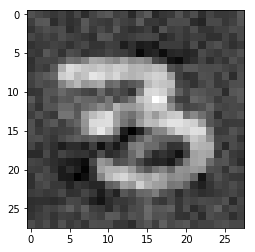

In [55]:
eps=3
XT_perturbed = []
for i in range(len(pm)):
    XT_perturbed.append(XT[i] - pm[i]*eps*grad[i])
XT_perturbed = np.asarray(XT_perturbed)
plt.imshow(XT_perturbed[yT==3][4].reshape(28,28),cmap=plt.cm.gray)
plt.show()

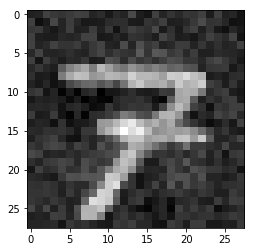

In [56]:
XT_perturbed = []
for i in range(len(pm)):
    XT_perturbed.append(XT[i] - pm[i]*eps*grad[i])
XT_perturbed = np.asarray(XT_perturbed)
plt.imshow(XT_perturbed[yT==7][7].reshape(28,28),cmap=plt.cm.gray)
plt.show()

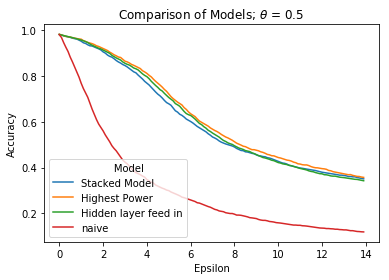

In [57]:
fig,ax = plt.subplots()
ax.plot(epsilon,score1)
ax.plot(epsilon,Thomas[len(Thomas)-1])
ax.plot(epsilon,score2)
ax.plot(epsilon,score3)
ax.set_title(r"Comparison of Models; $\theta$ = %.1f"%theta)
ax.set_xlabel("Epsilon")
ax.set_ylabel("Accuracy")
plt.legend(['Stacked Model','Highest Power','Hidden layer feed in','naive'], title = "       Model", loc=3)
plt.savefig("rs.png")

In [58]:
final = True
for i in range(len(score1)):
    if (score1[i]<0.8 and final):
        print(epsilon[i])
        final = False
final = True
for i in range(len(Thomas[len(Thomas)-1])):
    if (Thomas[len(Thomas)-1][i]<0.8 and final):
        print(epsilon[i])
        final = False
final = True
for i in range(len(score1)):
    if (score2[i]<0.8 and final):
        print(epsilon[i])
        final = False

3.7
4.2
4.0


In [ ]:
X0_adv_test = np.zeros(X0_test.shape)
theta = 0.5
epsilon = np.arange(0,0.5,0.01)
Ns = np.arange(11)
score = np.zeros((len(Ns),len(epsilon)))
for idx_eps,eps in enumerate(epsilon):
    X0_adv_test[y_test == 3] = adv_per3(X0_test[y_test == 3],eps,delta)
    X0_adv_test[y_test == 7] = adv_per7(X0_test[y_test == 7],eps,delta)
    for idx_N,N in enumerate(Ns):
        X1_adv_test = hill(X0_adv_test,N,theta)
        score[idx_N,idx_eps]=mlp_orig.score(X1_adv_test,y_test)

In [ ]:
fig,ax = plt.subplots()
for line in score[range(2,12,2),:]:
    ax.plot(epsilon,line)
    ax.set_title(r"Even powers; $\theta$ = %.1f"%theta)
    ax.set_xlabel("Epsilon")
    ax.set_ylabel("Accuracy")
    plt.legend([2,4,6,8,10], title = "       N")
    #plt.savefig("../Figures/Even-powers.png")
    
fig,ax = plt.subplots()
for line in score[range(1,11,2),:]:
    ax.plot(epsilon,line)
    ax.set_title(r"Odd powers; $\theta$ = %.1f"%theta)
    ax.set_xlabel("Epsilon")
    ax.set_ylabel("Accuracy")
    plt.legend(range(1,11,2), title = "        N")
    #plt.savefig("../Figures/Odd-powers.png")

plt.show()

In [ ]:
score_naive = np.zeros((len(epsilon),1))
for idx_eps,eps in enumerate(epsilon):
    X0_adv_test[y_test == 3] = adv_per3(X0_test[y_test == 3],eps,delta)
    X0_adv_test[y_test == 7] = adv_per7(X0_test[y_test == 7],eps,delta)
    score_naive[idx_eps]=mlp_orig.score(X0_adv_test,y_test)

In [ ]:
for line in score_naive.T:
    plt.plot(epsilon,line)
    plt.title("Naive adversarial perturbation")
    plt.legend(["No transformation"])
plt.show()

## Compute gradient manually

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def relu(x):
    for i in range(len(x)):
        x[i] = np.max((0,x[i]))
    return x

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def relu(x):
    for i in range(len(x)):
        x[i] = np.max((0,x[i]))
    return x
def hill(x,n,theta):
#     return x**n
    return x**n/(x**n + theta**n)

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def relu(x):
    for i in range(len(x)):
        x[i] = np.max((0,x[i]))
    return x
def hill(x,n,theta):
#     return x**n
    return x**n/(x**n + theta**n)
def score(x,use_hill,N,theta,mlp):
    W = mlp.coefs_
    b = mlp.intercepts_
    if use_hill:
        y = hill(x,N,theta)
    else:
        y = x[:]
    return sigmoid(np.dot(relu(np.dot(y,W[0])+b[0]),W[1])+b[1])

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def relu(x):
    for i in range(len(x)):
        x[i] = np.max((0,x[i]))
    return x
def hill(x,n,theta):
#     return x**n
    return x**n/(x**n + theta**n)
def score(x,use_hill,N,theta,mlp):
    W = mlp.coefs_
    b = mlp.intercepts_
    if use_hill:
        y = hill(x,N,theta)
    else:
        y = x[:]
    return sigmoid(np.dot(relu(np.dot(y,W[0])+b[0]),W[1])+b[1])
def grad_score(x,use_hill,N,theta,mlp):
    grad = np.zeros(x.shape)
    for i in range(len(x)):
        yp = x.copy(); yp[i] += 10/255; 
        ym = x.copy(); ym[i] -= 10/255;
        grad[i] = 255/2*(score(yp,use_hill,N,theta,mlp)-score(ym,use_hill,N,theta,mlp))
    return grad

In [ ]:
def iter_grad(x0,use_hill,N,theta,mlp,eps):
    num_iter = 0; 
    x = x0.copy()
    pred = mlp.predict(x0.reshape(1,-1))
    new_pred = mlp.predict(x.reshape(1,-1))
    pm = (pred-5)/2 #3 -> -1; 7 -> +1
    while new_pred == pred:
        grad = grad_score(x,use_hill,N,theta,mlp)
        x -= pm*eps*grad[:]
        new_pred = mlp.predict(x.reshape(1,-1))
        print(score(x,use_hill,N,theta,mlp))
        num_iter += 1
    return x,num_iter

In [ ]:
use_hill=True;N=10;theta=0.5
x0 = X0_test[y_test==3][1000]
grad = grad_score(x0,True,N,theta,mlp_orig)
plt.imshow(grad.reshape(28,28),cmap=plt.cm.gray)
plt.axis('off');plt.show()

In [ ]:
x0 = X0_test[y_test==7][1000]
x1,num_iter = iter_grad(x0,True,10,theta,mlp_orig,5)
fig,ax = plt.subplots(1,2)
ax[0].imshow(x0.reshape(28,28),cmap=plt.cm.gray)
ax[1].imshow(x1.reshape(28,28),cmap=plt.cm.gray)
# ax[2].imshow(hill(x.reshape(28,28),N,theta),cmap=plt.cm.gray)

[a.axis('off') for a in ax]
plt.show()

In [ ]:
sample = [int(len(X0_test)*random.random()) for _ in range(10)]

for i in sample:
    x = X0_test[i]
    grad_xF = grad_score(x,False,0,0,mlp_orig)
    print(sum(grad_xF**2))
    grad_xT = grad_score(x,True,10,0.5,mlp_orig)
    fig,ax = plt.subplots(1,3)
    ax[0].imshow(x.reshape(28,28),cmap=plt.cm.gray)
    ax[1].imshow((grad_xF).reshape(28,28),cmap=plt.cm.gray)
    ax[2].imshow((grad_xT).reshape(28,28),cmap=plt.cm.gray)
    [a.axis('off') for a in ax]
    plt.show()
# print(grad)

In [ ]:
print(score(x,False,0,0,mlp_orig))
print(y_test[num])

In [ ]:
num = 1360
eps = 0.5
use_hill = True
N = 2
theta = 0.8
x = X0_test[y_test == 3][num].copy()
pred = y_test[y_test == 3][num]
# pred = score(x,use_hill,N,theta,mlp_orig)
print(pred)
num_iter = 0
# while pred == y_test[num]:
while pred < 0.98:
    print(score(x,use_hill,N,theta,mlp_orig))
    grad = grad_score(x,use_hill,N,theta,mlp_orig)
    if y_test[num] == 3:
        x += eps*grad[:]
    elif y_test[num] == 7:
        x -= eps*grad[:]
#     pred = mlp_orig.predict(x.reshape(1,-1))
    pred = score(x,use_hill,N,theta,mlp_orig)
    num_iter += 1
print(num_iter)
fig,ax = plt.subplots(1,3)
ax[0].imshow(X0_test[y_test == 3][num].reshape(28,28),cmap=plt.cm.gray)
ax[1].imshow(grad.reshape(28,28),cmap=plt.cm.gray)
ax[2].imshow(hill(x.reshape(28,28),N,theta),cmap=plt.cm.gray)
[a.axis('off') for a in ax]
plt.show()

In [ ]:
for i in np.arange(2,30,4):
    y = hill(x.reshape(1,-1),i,theta)
    print(i, mlp_orig.predict(y))
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(hill(X0_test[num].reshape(28,28),i,theta),cmap=plt.cm.gray)
    ax[1].imshow(y.reshape(28,28),cmap=plt.cm.gray)
    [a.axis('off') for a in ax]
    plt.show()

In [ ]:
sample = [int(len(X0_test[y_test == 7])*random.random()) for _ in range(5)]
print(sample)
score7 = [print(score(X0_test[y_test == 7][i],False,0,0,mlp_orig)) for i in sample]
for i in sample:
    x = X0_test[y_test == 7][i]
    plt.imshow(x.reshape(28,28),cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

In [ ]:
N = 2; theta = 0.8
sample = [1359, 189, 1314, 366, 1129, 1045]
epsilon = np.arange(0.2,1.2,0.2)
num_iter_table = [np.zeros((len(sample),len(epsilon)))]*2

for i,x in enumerate(X0_test[y_test==7][sample]):
    for j,eps in enumerate(epsilon):
        num_iter_table[0][i,j] = iter_grad(x,7,False,N,theta,mlp_orig,eps)
        num_iter_table[1][i,j] = iter_grad(x,7,True,N,theta,mlp_orig,eps)
pprint(num_iter_table[0])
pprint(num_iter_table[1])